In [1]:
import torch
import pandas as pd
import numpy as np
import importlib
import ModelRunner as MR
import MakeDataset as MD
import SiameseNeuralNetwork as SNN
from matplotlib import pyplot as plt

In [2]:
# Load the dataset. 
# molecule_features: First col is a string containing name of molecule. Rest are floats containing its features
# eutectic_compilation: First 2 cols are strings containing molecule names, third col is eutectic proportion, fourth is eutectic temperature
molecule_features = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\single_components.csv").drop(["xlogp"], axis=1)
eutectic_compilation = pd.read_csv("D:\\Research\\UConn_ML\\data\\eutectic_mixtures-main\\eutectic_compilation.csv")

molecule_features[molecule_features.columns[1:]] = molecule_features[molecule_features.columns[1:]].astype(float)
eutectic_compilation[eutectic_compilation.columns[3]] = eutectic_compilation[eutectic_compilation.columns[3]].astype(float)

# Some indices in eutectic_compilation do not exist in single_components. They will need to be removed.
# Some of the eutectic proportions are inconvertible to floats from strings. They will also need to be removed.
# missing_molecules will store all molecules that are missing features from eutectic_compilation
drops = np.array([]).astype(int)
missing_molecules = np.array([]).astype(str)
for i in range(len(eutectic_compilation)):
    ec = eutectic_compilation.iloc[i]
    m1 = ec[0]
    m2 = ec[1]
    xe = ec[2]
    
    m1f = molecule_features.loc[molecule_features.mol == ec[0]]
    m2f = molecule_features.loc[molecule_features.mol == ec[1]]
    
    try:
        xe = float(xe)
    except ValueError:
        drops = np.append(drops, i)
    
    if(len(m1f) == 0 or len(m2f) == 0):
        drops = np.append(drops, i)
        
        if(len(m1f) == 0):
            missing_molecules = np.append(missing_molecules, m1)
        elif(len(m2f) == 0):
            missing_molecules = np.append(missing_molecules, m2)

eutectic_compilation = eutectic_compilation.drop(eutectic_compilation.index[drops])
# np.savetxt("missing_molecules.csv", missing_molecules, delimiter=",", fmt="%s")

xe = torch.tensor(np.array(eutectic_compilation.xe).astype(float) / 100.0)
eutectic_compilation.xe = xe

In [3]:
# Z-score normalization on all molecule features
# weight = torch.tensor(np.array(molecule_features.molecular_weight).astype(float))
# complexity = torch.tensor(np.array(molecule_features.complexity).astype(float))
# rotbond = torch.tensor(np.array(molecule_features.rotatable_bond_count).astype(float))
# heavyatom = torch.tensor(np.array(molecule_features.heavy_atom_count).astype(float))
# toparea = torch.tensor(np.array(molecule_features.topological_area).astype(float))

# molecule_features.molecular_weight = torch.abs((weight - torch.mean(weight)) / (torch.std(weight) + 1e-9))
# molecule_features.complexity = torch.abs((complexity - torch.mean(complexity)) / (torch.std(complexity) + 1e-9))
# molecule_features.rotatable_bond_count = torch.abs((rotbond - torch.mean(rotbond)) / (torch.std(rotbond) + 1e-9))
# molecule_features.heavy_atom_count = torch.abs((heavyatom - torch.mean(heavyatom)) / (torch.std(heavyatom) + 1e-9))
# molecule_features.topological_area = torch.abs((toparea - torch.mean(toparea)) / (torch.std(toparea) + 1e-9))

In [4]:
# Min-Max normalization of Te
Te = torch.tensor(np.array(eutectic_compilation.Te).astype(float))
eutectic_compilation.Te = (Te - min(Te)) / (max(Te) - min(Te))
# eutectic_compilation.Te = (Te - torch.mean(Te)) / (torch.std(Te) + 1e-8)

In [5]:
# Split the eutectic compilation dataframe by a ratio into training and testing sets
split = 0.95
train_ec = eutectic_compilation.sample(frac=split)
test_ec = eutectic_compilation.drop(train_ec.index)

split = 0.10
val_ec = train_ec.sample(frac=split)
train_ec = train_ec.drop(val_ec.index)

In [6]:
molecule_features

,mol,molecular_weight,complexity,rotatable_bond_count,heavy_atom_count,topological_area
0,BaO,153.3300,2.0,0.0,2.0,17.1
1,CrCl3,158.3500,0.0,0.0,4.0,0.0
2,PBr5,430.4900,37.1,0.0,6.0,0.0
3,WCl5,361.1000,37.1,0.0,6.0,0.0
4,HgI2,454.4000,2.8,0.0,3.0,0.0
...,...,...,...,...,...,...
672,PBr3,270.6900,8.0,0.0,4.0,0.0
673,PbSiO3,283.0000,18.8,0.0,5.0,63.2
674,LiI,133.9000,2.0,0.0,2.0,0.0
675,EuF3,208.9590,8.0,0.0,4.0,0.0


In [7]:
eutectic_compilation

,molA,molB,xe,Te
0,BF3,N2O,0.766,0.000000
1,BF3,SO2,0.952,0.003312
2,BCl3,GeCl4,0.760,0.007752
3,BCl3,PCl3,0.940,0.009866
4,BCl3,PCl3,0.200,0.013742
...,...,...,...,...
4463,Sc2O3,ZrO2,0.522,0.911910
4464,UO2,ZrO2,0.475,0.947146
4465,UO2,ZrO2,0.500,0.947146
4466,UN,W,1.000,1.000000


In [8]:
train_ec

,molA,molB,xe,Te
2289,PbBr2,Rb2CO3,0.605,0.248062
1284,CsCl,SnCl2,0.630,0.171952
247,AlCl3,POCl3,0.635,0.088901
4136,B2O3,MgO,0.179,0.527837
2048,CsCl,FeCl2,0.735,0.232558
...,...,...,...,...
660,AgI,TlI,0.690,0.120860
2046,LiBr,LiCl,0.581,0.232206
3847,ErF3,NaF,0.720,0.372798
1980,LiBr,NaBr,0.830,0.227273


In [9]:
val_ec

,molA,molB,xe,Te
195,CaBr,GaBr3,0.2000,0.082100
1566,HoCl3,NaCl,0.5300,0.198027
2177,CsCl,MgCl2,0.3060,0.241720
136,SbCl3,WCl6,1.0000,0.074348
216,AlCl3,KBr,0.6550,0.085271
...,...,...,...,...
2451,CaCl2,KCl,0.2570,0.257928
2711,BaCl2,NaCl,0.4150,0.274137
318,LiNO3,TlNO3,0.3100,0.096723
1963,CoCl2,RbCl,0.2800,0.225863


In [10]:
test_ec

,molA,molB,xe,Te
1,BF3,SO2,0.9520,0.003312
26,BBr3,GeBr4,0.8090,0.029951
28,GeCl4,SnCl4,0.9100,0.030550
29,GeCl4,TiCl4,0.9670,0.030726
31,PBr3,SnBr4,0.8400,0.031008
...,...,...,...,...
4297,Al2O3,CaO,0.6740,0.674066
4308,CaTiO3,Cr2O3,0.5770,0.685342
4338,Al2O3,La2O3,0.2621,0.709302
4387,Cr2O3,Y2O3,0.2800,0.760395


In [11]:
print("Train Size: ", len(train_ec))
print("Validation Size: ", len(val_ec))
print("Test Size: ", len(test_ec))

Train Size:  3403
Validation Size:  378
Test Size:  199


In [12]:
importlib.reload(MD)

<module 'MakeDataset' from 'D:\\Research\\UConn_ML\\Code\\MakeDataset.py'>

In [19]:
# Define parameters and datasets to pass into trainer. Pass in order of definition
starting_features = 5
batchsize = 30
max_epochs = 30
lrbase = 1e-6
lrmax = 1e-4
train_dset = MD.MD(train_ec, molecule_features, starting_features)
val_dset = MD.MD(val_ec, molecule_features, starting_features)
test_dset = MD.MD(test_ec, molecule_features, starting_features)

# Set the baselines for training, validation, and testing
# MAE is basically standard deviation, so the baseline is the std of the dataset
# MAE tells us how much + or - pred is from truth on average
train_stdev = torch.std(torch.tensor(np.array(train_ec["xe"]).astype(float) / 100.0))
# train_stdev = torch.std(torch.tensor(np.array(train_ec["Te"]).astype(float)))

train_param = "xe"

In [20]:
# Call training and testing class and send all required parameters 
importlib.reload(MR)
importlib.reload(SNN)
modelrunner = MR.MR(starting_features, batchsize, max_epochs, lrbase, lrmax, 
                    train_dset, val_dset, test_dset, train_stdev, train_param)

trloss, trbase, vloss, vbase = modelrunner.train_and_validate()
outputs, invouts, truths = modelrunner.test()

Epoch 1 | Train Loss: 0.437538 | Train Baseline: 0.502037 | Val Loss: 0.43154 | Val Baseline: 0.500202
Epoch 2 | Train Loss: 0.43725 | Train Baseline: 0.502037 | Val Loss: 0.431267 | Val Baseline: 0.500202
Epoch 3 | Train Loss: 0.436998 | Train Baseline: 0.502037 | Val Loss: 0.430691 | Val Baseline: 0.500202
Epoch 4 | Train Loss: 0.436123 | Train Baseline: 0.502037 | Val Loss: 0.429865 | Val Baseline: 0.500202
Epoch 5 | Train Loss: 0.435927 | Train Baseline: 0.502037 | Val Loss: 0.429349 | Val Baseline: 0.500202
Epoch 6 | Train Loss: 0.434741 | Train Baseline: 0.502037 | Val Loss: 0.428105 | Val Baseline: 0.500202
Epoch 7 | Train Loss: 0.433601 | Train Baseline: 0.502037 | Val Loss: 0.426842 | Val Baseline: 0.500202
Epoch 8 | Train Loss: 0.432207 | Train Baseline: 0.502037 | Val Loss: 0.425846 | Val Baseline: 0.500202
Epoch 9 | Train Loss: 0.429898 | Train Baseline: 0.502037 | Val Loss: 0.423501 | Val Baseline: 0.500202
Epoch 10 | Train Loss: 0.428536 | Train Baseline: 0.502037 | Val L

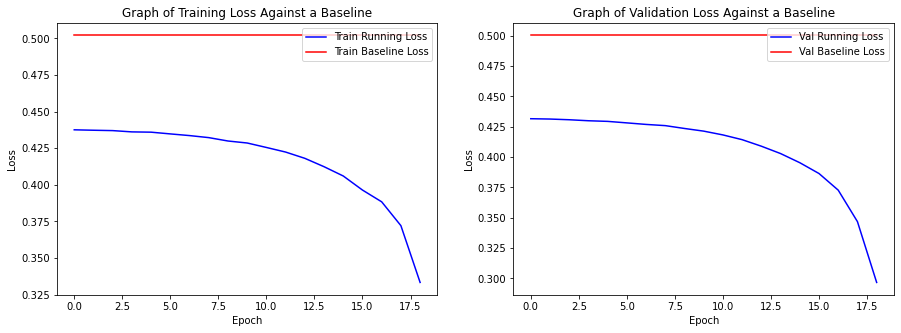

In [21]:
l = len(trloss)
x = np.arange(l)
fig, axes = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
            
axes[0].plot(x, trloss[0:l], label="Train Running Loss", c="blue")
axes[0].plot(x, trbase[0:l], label="Train Baseline Loss", c="red")
axes[0].set_title("Graph of Training Loss Against a Baseline")
axes[0].set(xlabel="Epoch", ylabel="Loss")
axes[0].legend(loc="upper right")

axes[1].plot(x, vloss[0:l], label="Val Running Loss", c="blue")
axes[1].plot(x, vbase[0:l], label="Val Baseline Loss", c="red")
axes[1].set_title("Graph of Validation Loss Against a Baseline")
axes[1].set(xlabel="Epoch", ylabel="Loss")
axes[1].legend(loc="upper right")

plt.show()

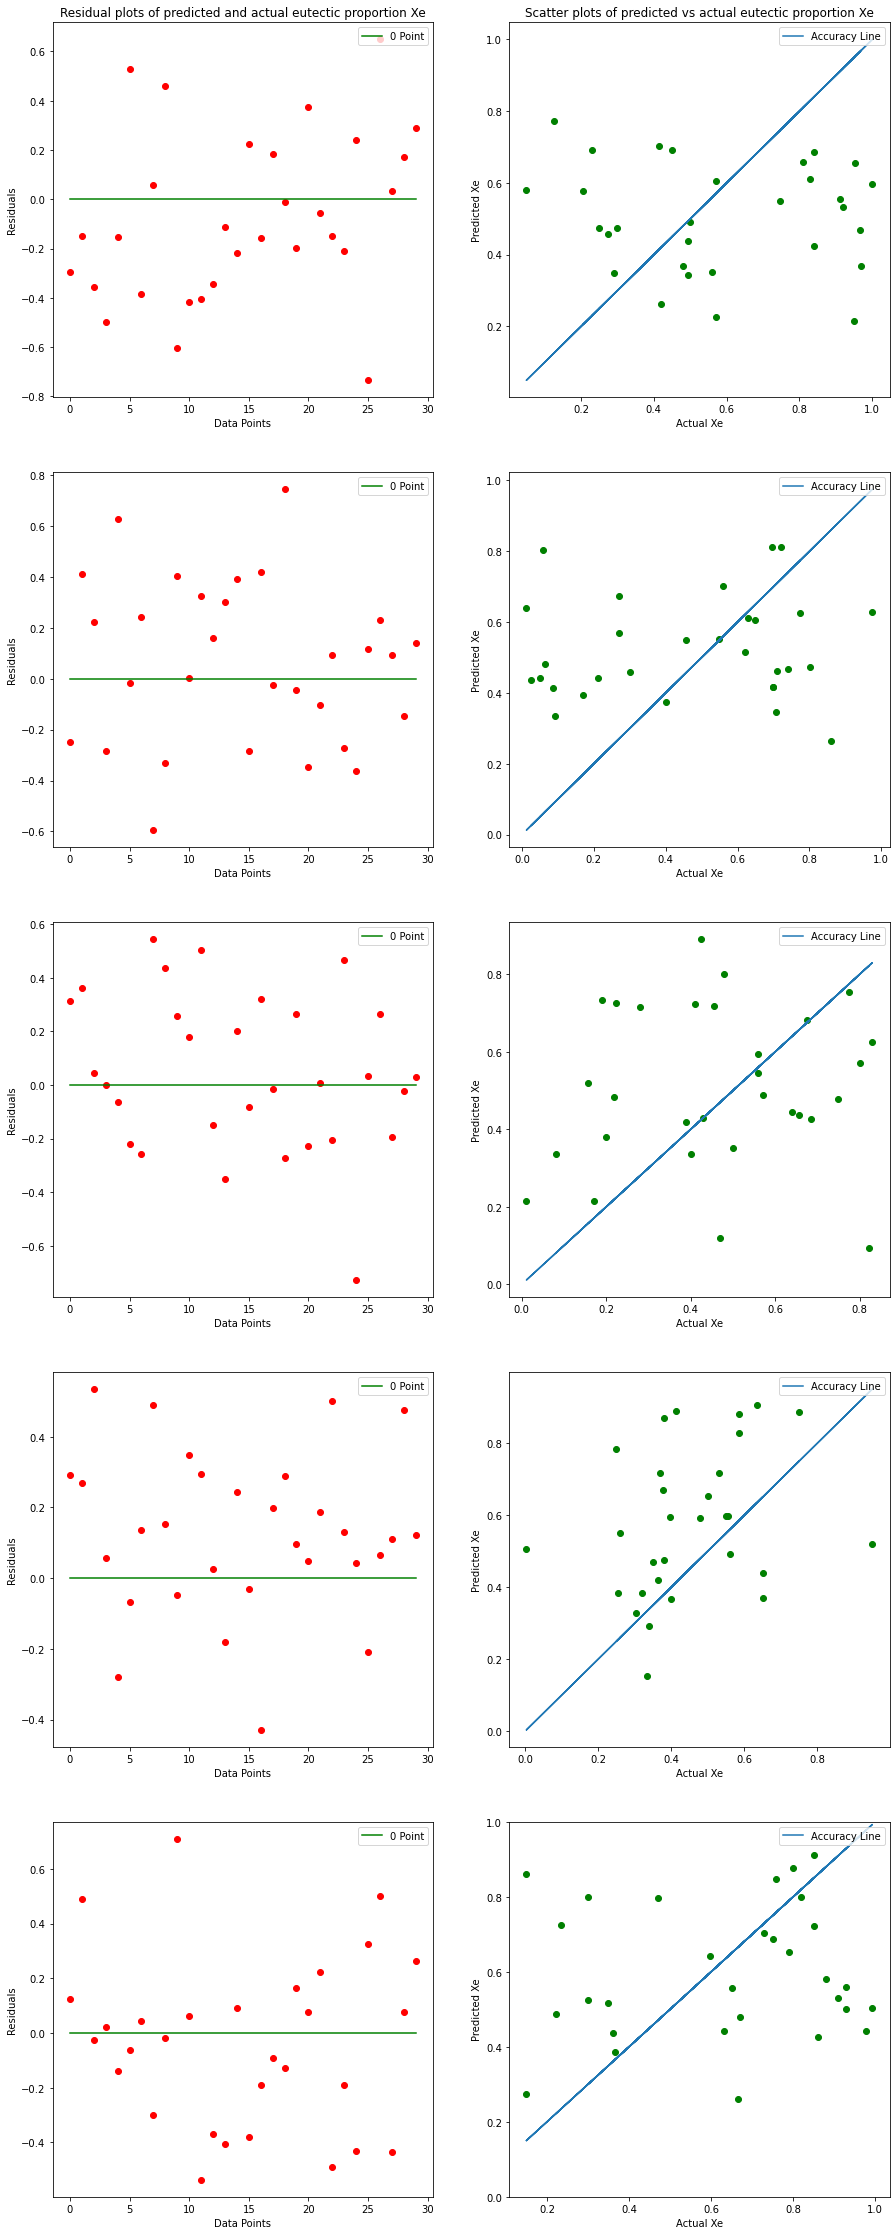

In [22]:
fig, axes = plt.subplots(5, 2)
fig.set_figheight(40)
fig.set_figwidth(15)

l = batchsize
pred = 0
succ = 1
x = np.arange(l)
        
for row in range(5):
    axes[row, 0].scatter(x, outputs[pred*l:succ*l] - truths[pred*l:succ*l], c="red")
    axes[row, 0].plot(x, np.zeros((l,)), c="green", label="0 Point")
    axes[row, 0].set(xlabel="Data Points", ylabel="Residuals")
    axes[row, 0].legend(loc="upper right")

    axes[row, 1].scatter(truths[pred*l:succ*l], outputs[pred*l:succ*l], c="green")
    axes[row, 1].plot(truths[pred*l:succ*l], truths[pred*l:succ*l], label="Accuracy Line")
    
    if train_param == "xe":
        axes[row, 1].set(xlabel="Actual Xe", ylabel="Predicted Xe")
    else:
        axes[row, 1].set(xlabel="Actual Te", ylabel="Predicted Te")

    axes[row, 1].legend(loc="upper right")

    plt.ylim([0, 1])
            
    pred += 1
    succ += 1

if train_param == "xe":
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic proportion Xe")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic proportion Xe")
else:
    axes[0, 0].set_title("Residual plots of predicted and actual eutectic temperature Te")
    axes[0, 1].set_title("Scatter plots of predicted vs actual eutectic temperature Te")
    
plt.show()

In [23]:
# Print the values from the last batch processed just for the user to see
if train_param == "xe":
    disp = pd.DataFrame({
        'f(A,B)': np.round(outputs[0:l], 3),
        'f(B,A)': np.round(invouts[0:l], 3),
        'f(A,B) + f(B,A)': outputs[0:l] + invouts[0:l],
        'Truth': np.round(truths[0:l], 3),
        'Pred': np.round(outputs[0:l], 3)})
else:
    disp = pd.DataFrame({
        'Truth': np.round(truths[0:l], 3),
        'Pred': np.round(outputs[0:l], 3)})
        
disp.style.set_properties(**{'width': '150px'})

,"f(A,B)","f(B,A)","f(A,B) + f(B,A)",Truth,Pred
0,0.655000,0.345000,1.000000,0.952000,0.655000
1,0.659000,0.341000,1.000000,0.809000,0.659000
2,0.556000,0.444000,1.000000,0.910000,0.556000
3,0.470000,0.530000,1.000000,0.967000,0.470000
4,0.687000,0.313000,1.000000,0.840000,0.687000
5,0.580000,0.420000,1.000000,0.050000,0.580000
6,0.534000,0.466000,1.000000,0.920000,0.534000
7,0.349000,0.651000,1.000000,0.291000,0.349000
8,0.691000,0.309000,1.000000,0.230000,0.691000
9,0.368000,0.632000,1.000000,0.970000,0.368000


In [25]:
# fig.savefig('D:\\Research\\UConn_ML\\Images\\plots_7_20_22.png')